In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Data cleansing v1
'''
id : 단순 id
url : 단순 url
title : purpose 칼럼에서 더 categorized 설명되는 내용
application_type : individual이 980개
next_pymnt_d : 칼럼이 비어 있음
policy_code : 값이 모두 1임
chargeoff_within_12_mths : 0이 995개
delinq_amnt : 0이 997개
num_tl_120dpd_2m : 0이 아닌 값이 딱 1개
num_tl_30dpd : 0이 아닌 값이 딱 2개
hardship_flag : 값이 모두 N
disbursement_method : cash가 997개
'''
 
df = pd.read_csv("lending_club_sample.csv")
df = df.drop(columns=["id",
                      "url",
                      "title",
                      "application_type",
                      "next_pymnt_d",
                      "policy_code",
                      "chargeoff_within_12_mths",
                      "delinq_amnt",
                      "num_tl_120dpd_2m",
                      "num_tl_30dpd",
                      "hardship_flag",
                      "disbursement_method"])

df.to_csv("data_preprocessed_v1.csv", index=False)

In [56]:
# Data cleansing v3
df = pd.read_csv("./data_preprocessed_v1.csv")

# grade, sub_grade
# categorical variable(ordinal variable) Labeling
og_grade = df["grade"]
og_sub_grade = df["sub_grade"]

grade = np.array(df["grade"])
sub_grade = np.array(df["sub_grade"])

encoder = LabelEncoder()
grade_encoded = encoder.fit_transform(grade)
sub_grade_encoded = encoder.fit_transform(sub_grade)

df["grade"] = grade_encoded
df["sub_grade"] = sub_grade_encoded

# data cleansing. drop columns which has under 50 datas
df = df.loc[:, df.count() >= 50]

# fico_range_low
# data cleansing. add avg fico score column 
insert_loc = df.columns.get_loc('fico_range_low')
df.insert(insert_loc, 'fico_avg', (df['fico_range_low'] + df['fico_range_high']) / 2)

# emp_length
# 2 way of emp_length mapping.
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 0~10
# emp_length이 NaN인 값(무직)을 -1로 매핑, 나머지를 오름차순으로 1~11. 무직과 고용상태를 구분하기 위함
label_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(label_mapping)
df['emp_length'] = df['emp_length'].fillna(-1)

# term
# categorical variable Labeling
label_mapping = {
    ' 36 months': 36,
    ' 60 months': 60
}

df['term'] = df['term'].map(label_mapping)

# mths_since_last_delinq
# 최종 연체 후 경과 개월 수
# 연체가 있었는지 없었는지 binary로 구분하는 데이터로 사용하면 될듯
# 연체가 없었으면 0, 있었으면 1
insert_loc = df.columns.get_loc('mths_since_last_delinq')
df.insert(insert_loc, 'delinq_flag', np.where(df['mths_since_last_delinq'].isna(), 0, 1))

# mths_since_last_record
# 마지막 파산 기록 이후 경과된 개월 수
# 이거 유용한 정보인거 같긴 한데, 한국어 번역에 문제가 있는 것같다. 영어 원문에 public record라고 써있는데, public record는 파산을 포함한 공적 기록을 의미한다. 따라서 꼭 파산이 아닐 수도 있음.
# https://credit.org/blogs/blog-posts/understanding-your-public-record-information 해당 링크에 따르면, 판결 등의 정보도 public record에 포함된다.
# 일단 drop

# revol_util
# follow paper (Machine learning and artificial neural networks to construct P2P lending credit-scoring model: A case using Lending Club data), form change percentage form to decimal form
# 결측치는 평균값으로 채워넣는다
df['revol_util'] = df['revol_util'] / 100.0
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

# tot_coll_amt
# 총 채권 추심 금액
# 결측값만 처리
df["tot_coll_amt"] = df["tot_coll_amt"].fillna(0)

# tot_cur_bal
# 모든 계좌 현재 잔액 합계
# 결측값은 중앙값으로
df["tot_cur_bal"] = df["tot_cur_bal"].fillna(df["tot_cur_bal"].median())

# total_rev_hi_lim
# 리볼빙 총 한도
# 결측값은 중앙값으로
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].fillna(df["total_rev_hi_lim"].median())

# acc_open_past_24mths
# 최근 24개월 동안 개설된 신용거래 건수
# 결측값은 중앙값으로
df["acc_open_past_24mths"] = df["acc_open_past_24mths"].fillna(df["acc_open_past_24mths"].median())

# avg_cur_bal
# 모든 계좌의 평균 현재 잔액
# 결측값은 중앙값으로
df["avg_cur_bal"] = df["avg_cur_bal"].fillna(df["avg_cur_bal"].median())

# bc_open_to_buy
# 리볼빙 은행카드 사용 가능 한도
# 결측값은 중앙값으로
df["bc_open_to_buy"] = df["bc_open_to_buy"].fillna(df["bc_open_to_buy"].median())

# bc_util
# 은행카드 한도 대비 잔액 비율
# 결측값은 평균값으로
df['bc_util'] = df['bc_util'] / 100.0
df['bc_util'] = df['bc_util'].fillna(df['bc_util'].mean())

# mort_acc
# 주택담보대출 계좌 수
# 결측값은 중앙값으로
df["mort_acc"] = df["mort_acc"].fillna(df["mort_acc"].median())

# num_accts_ever_120_pd
# 120일 이상 연체 경험 계좌 수
# 결측값은 중앙값으로
df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(df["num_accts_ever_120_pd"].median())

# num_actv_bc_tl
# num_actv_rev_tl
# num_bc_sats
# num_bc_tl
# num_il_tl
# num_op_rev_tl
# num_rev_accts
# num_rev_tl_bal_gt_0
# num_sats
# 다 현재 계좌 수에 관련된 칼럼. 나중에 보고 좀 합쳐야할듯
# 결측값은 중앙값으로
cols = [
    'num_actv_bc_tl',
    'num_actv_rev_tl',
    'num_bc_sats',
    'num_bc_tl',
    'num_il_tl',
    'num_op_rev_tl',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'num_sats'
]

df[cols] = df[cols].fillna(df[cols].median())

# num_tl_90g_dpd_24m : 최근 24개월 90일 이상 연체 계좌 수
# num_tl_op_past_12m : 최근 12개월 개설 계좌 수
# tot_hi_cred_lim : 총 최고 신용 한도
# total_bal_ex_mort : 주택담보 제외 총 잔액
# total_bc_limit : 은행카드 총 한도
# total_il_high_credit_limit : 할부 계좌 총 한도
# 결측값은 중앙값으로
cols = [
    'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m',
    'tot_hi_cred_lim',
    'total_bal_ex_mort',
    'total_bc_limit',
    'total_il_high_credit_limit'
]

df[cols] = df[cols].fillna(df[cols].median())

# pct_tl_nvr_dlq : 연체 경험 없는 계좌 비율
# percent_bc_gt_75 : 한도 75% 초과 은행카드 계좌 비율
# 결측값은 평균으로
cols = ['pct_tl_nvr_dlq', 'percent_bc_gt_75']

df[cols] = df[cols].fillna(df[cols].mean())

# drop columns
'''
모델링을 위해 필요없어보이는 칼럼을 삭제. 추후에 재검토를 통해 살려서 다시 쓸 수도 있음
zip_code : 알아보니 zip_code 앞 3자리로는 state + city까지 알 수 있던데, 일단 addr_state에서 state는 알 수 있으니 탈락
fico_range_low : fico_range_high와 평균내어 fico_avg라는 파생변수로 만듬
desc : 대출 이유 설명 칸인데, nlp로 사용할 여지가 있긴 하지만 비어있는 칼럼 비율이 너무 높음. 92.7%
emp_title : 직업이 labeling하기 힘들 정도로 다양하기도 하고 근속 연수와 소득이 더 직관적인 데이터라고 생각해서 탈락
mths_since_last_delinq : 연체 여부를 판단하는 binary type 파생변수로 만듬. delinq_falg
mths_since_last_record : 일단 drop, 위 사유 참조
last_pymnt_d : 변수가 뭘 의미하는지 모르겠어서 일단 드랍. 시계열 데이터와 연관 있는거라면, 모델 개입 시점 때문에 탈락
mths_since_last_major_derog : 90일 이상 연체 여부인데, 연체 여부랑 크게 다를거 같지 않아서 일단 탈락
mo_sin_old_il_acct : 가장 오래된 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의
mo_sin_old_rev_tl_op : 
mo_sin_rcnt_rev_tl_op : 
mo_sin_rcnt_tl : 
mths_since_recent_bc : 최근 계좌 개설 후 지난 시간. 일단 지우고 도메인팀 협의 
mths_since_recent_bc_dlq : 
mths_since_recent_inq : 
mths_since_recent_revol_delinq : 

'''
df = df.drop(columns=["zip_code",
                      "fico_range_low",
                      "fico_range_high",
                      "desc",
                      "emp_title",
                      "mths_since_last_delinq",
                      "mths_since_last_record",
                      "last_pymnt_d",
                      "mths_since_last_major_derog",
                      "mo_sin_old_il_acct",
                      "mo_sin_old_rev_tl_op",
                      "mo_sin_rcnt_rev_tl_op",
                      "mo_sin_rcnt_tl",
                      "mths_since_recent_bc",
                      "mths_since_recent_bc_dlq",
                      "mths_since_recent_inq",
                      "mths_since_recent_revol_delinq"
                      ])

# 30% 이상 결측치를 가지는 칼럼 drop
df = df.loc[:, df.isnull().mean() < 0.3]

df.to_csv("./data_preprocessed_v3.csv", index=False)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag
0,20000.0,20000.0,20000.0,36,13.99,683.46,2,12,10.0,MORTGAGE,...,2.0,100.0,66.700000,0.0,0.0,759411.0,27732.0,17500.0,23245.0,N
1,7000.0,7000.0,7000.0,36,9.16,223.12,1,6,-1.0,OWN,...,4.0,96.6,25.000000,0.0,0.0,53672.0,28344.0,19200.0,23072.0,N
2,20000.0,20000.0,20000.0,36,8.67,632.93,1,5,10.0,MORTGAGE,...,1.0,89.7,57.100000,0.0,0.0,434045.0,47232.0,28300.0,32219.0,N
3,16000.0,16000.0,16000.0,36,14.46,550.43,2,13,5.0,OWN,...,0.0,84.0,33.300000,0.0,0.0,155587.0,81483.0,77000.0,73587.0,N
4,4000.0,4000.0,4000.0,36,11.53,131.97,1,9,2.0,MORTGAGE,...,2.0,73.7,46.724421,0.0,0.0,329177.0,91411.0,0.0,0.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21000.0,21000.0,21000.0,60,25.82,626.52,4,23,2.0,OWN,...,6.0,100.0,66.700000,0.0,0.0,377464.0,157456.0,12000.0,117101.0,N
996,10625.0,10625.0,10625.0,60,17.57,267.33,3,18,10.0,RENT,...,5.0,100.0,0.000000,1.0,0.0,89666.0,70977.0,6000.0,77266.0,N
997,7000.0,7000.0,7000.0,36,8.18,219.94,1,5,3.0,RENT,...,4.0,92.3,50.000000,0.0,0.0,71752.0,50074.0,10600.0,49652.0,N
998,8000.0,8000.0,8000.0,36,13.35,270.91,2,11,10.0,MORTGAGE,...,2.0,100.0,81.800000,0.0,0.0,59391.0,42018.0,19300.0,27423.0,N


In [68]:
# View categorical columns

df.select_dtypes(include=['object', 'category']).columns.tolist()
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,20000.0,20000.0,20000.0,36,13.99,683.46,2,12,10.0,65000.0,...,0.0,2.0,100.0,66.700000,0.0,0.0,759411.0,27732.0,17500.0,23245.0
1,7000.0,7000.0,7000.0,36,9.16,223.12,1,6,-1.0,35000.0,...,0.0,4.0,96.6,25.000000,0.0,0.0,53672.0,28344.0,19200.0,23072.0
2,20000.0,20000.0,20000.0,36,8.67,632.93,1,5,10.0,90000.0,...,0.0,1.0,89.7,57.100000,0.0,0.0,434045.0,47232.0,28300.0,32219.0
3,16000.0,16000.0,16000.0,36,14.46,550.43,2,13,5.0,50000.0,...,0.0,0.0,84.0,33.300000,0.0,0.0,155587.0,81483.0,77000.0,73587.0
4,4000.0,4000.0,4000.0,36,11.53,131.97,1,9,2.0,85000.0,...,0.0,2.0,73.7,46.724421,0.0,0.0,329177.0,91411.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,21000.0,21000.0,21000.0,60,25.82,626.52,4,23,2.0,125000.0,...,0.0,6.0,100.0,66.700000,0.0,0.0,377464.0,157456.0,12000.0,117101.0
996,10625.0,10625.0,10625.0,60,17.57,267.33,3,18,10.0,70000.0,...,0.0,5.0,100.0,0.000000,1.0,0.0,89666.0,70977.0,6000.0,77266.0
997,7000.0,7000.0,7000.0,36,8.18,219.94,1,5,3.0,50000.0,...,0.0,4.0,92.3,50.000000,0.0,0.0,71752.0,50074.0,10600.0,49652.0
998,8000.0,8000.0,8000.0,36,13.35,270.91,2,11,10.0,50550.0,...,0.0,2.0,100.0,81.800000,0.0,0.0,59391.0,42018.0,19300.0,27423.0


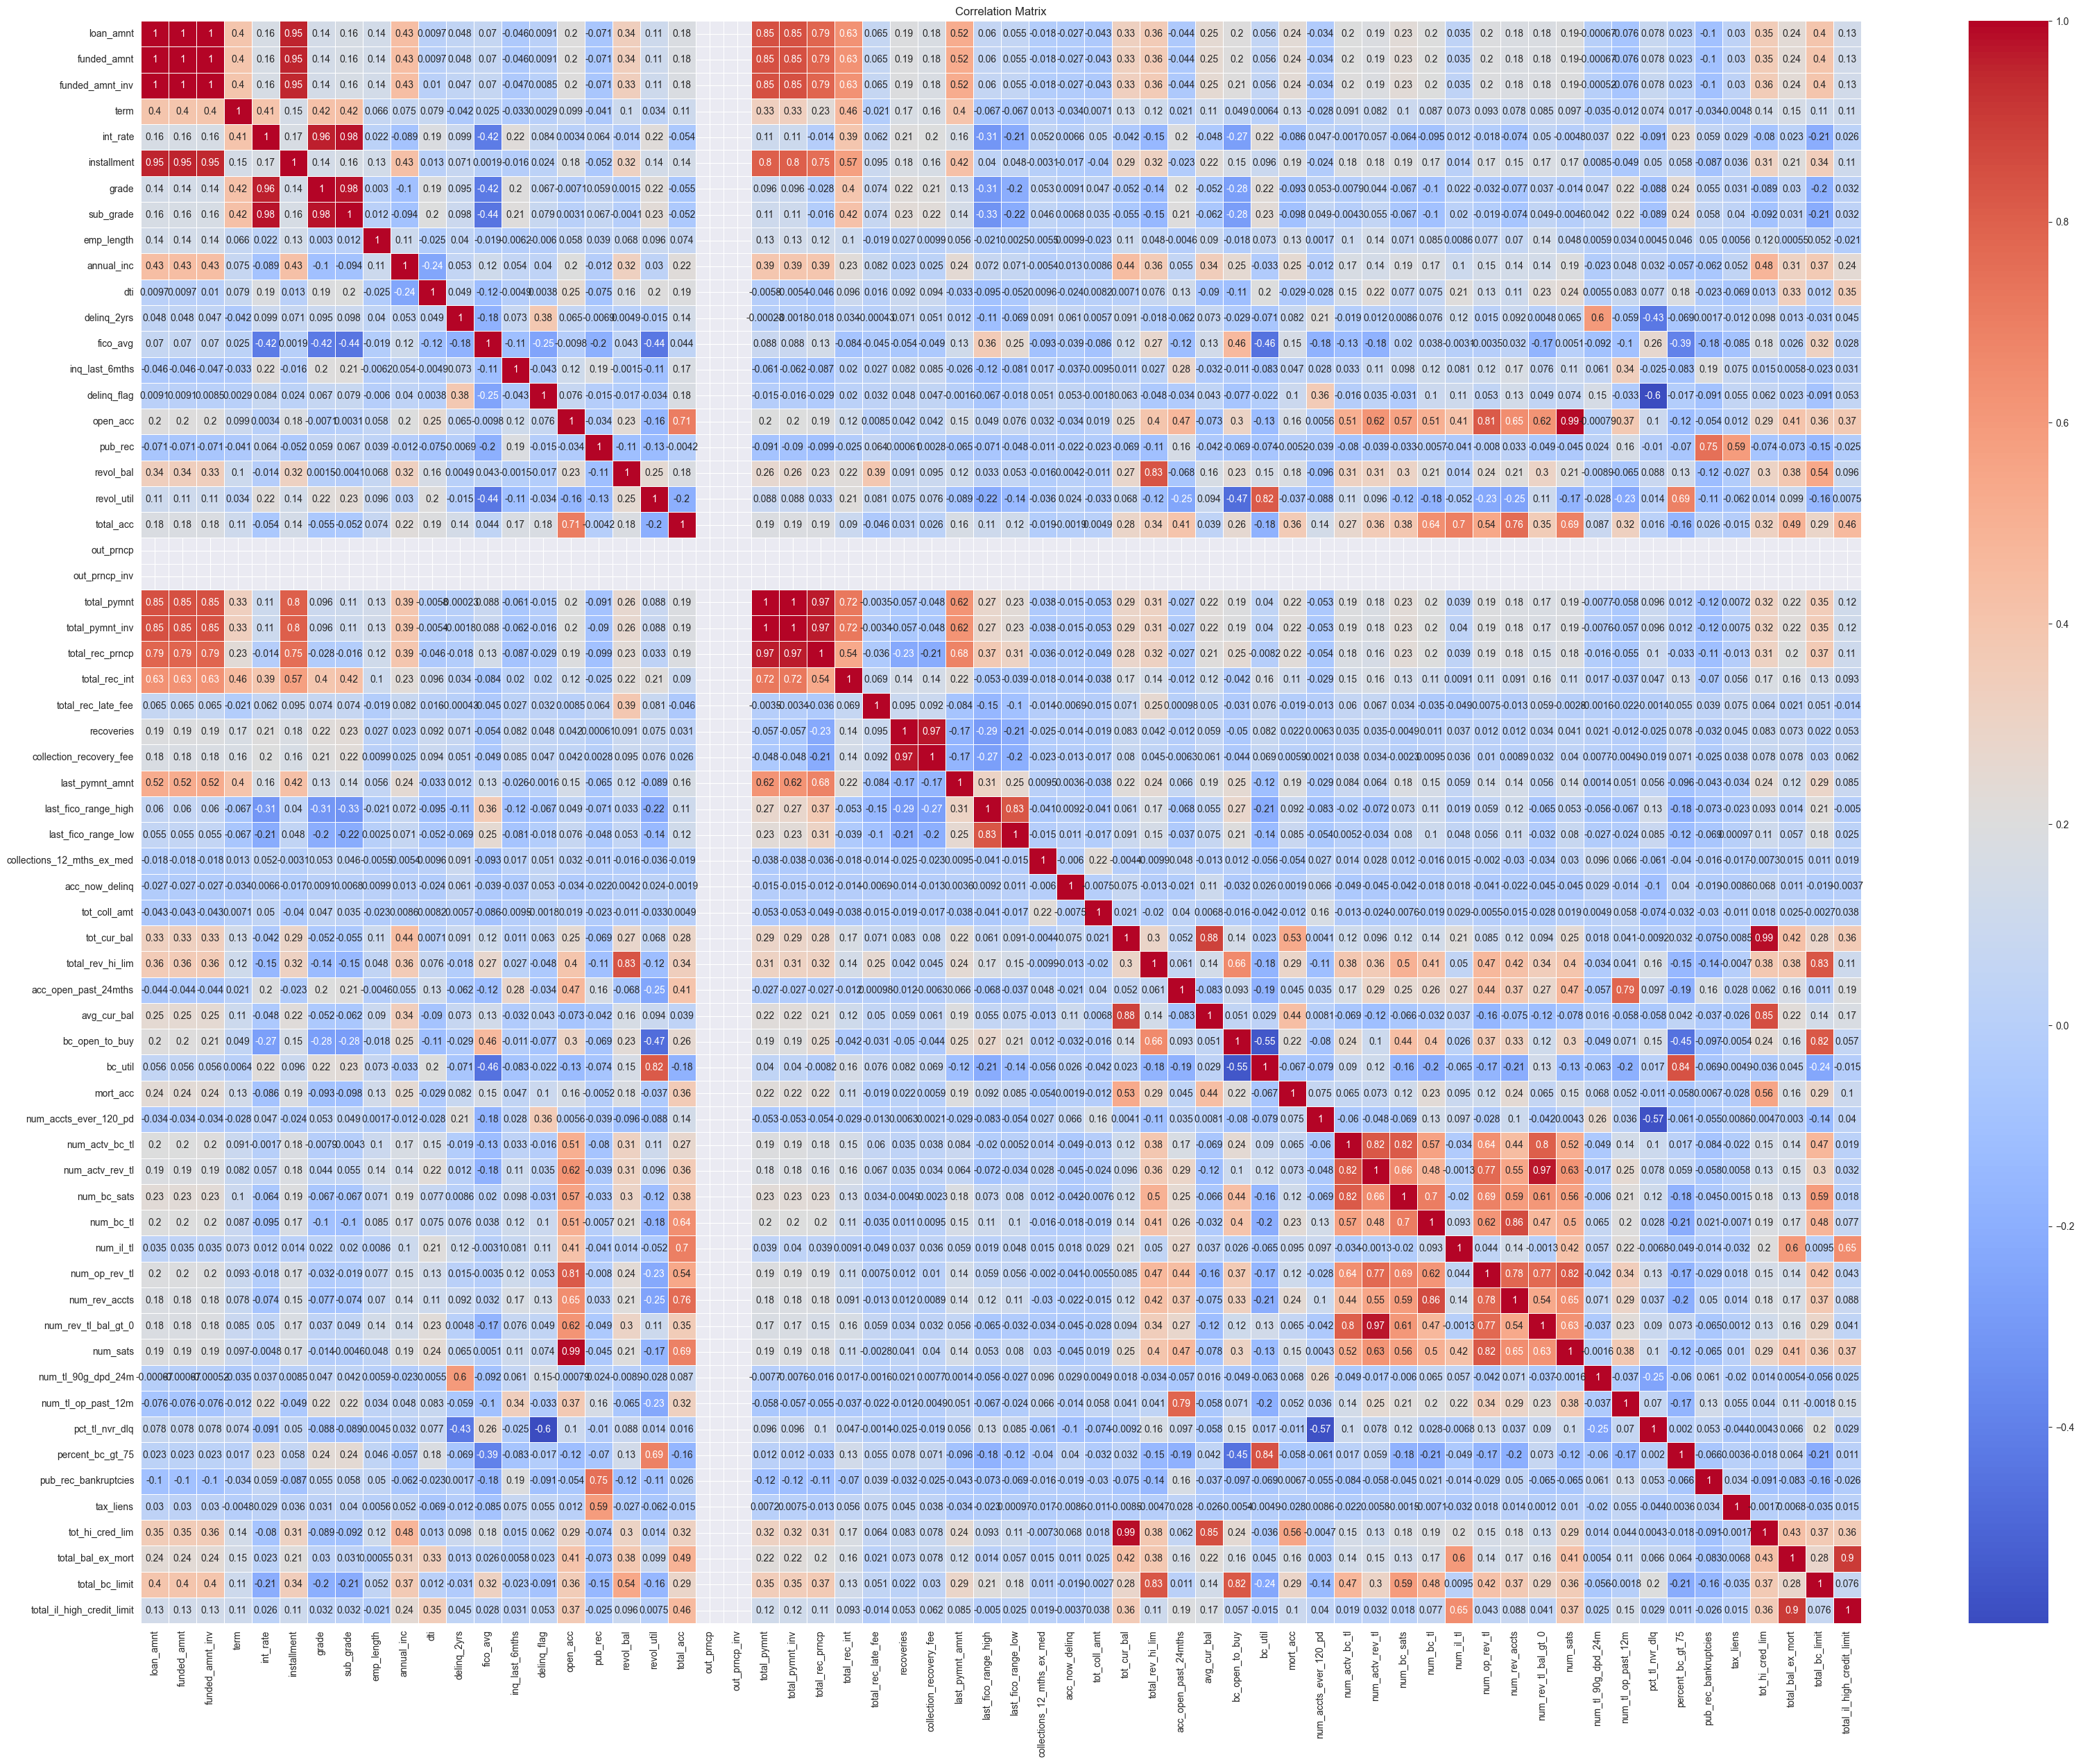

In [67]:
# CORR
# witout categorical columns

df = df.drop(columns=df.select_dtypes(include=['object', 'category']).columns.tolist())

corr_matrix = df.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.savefig("./correlation_matrix.jpg", dpi=600, bbox_inches='tight')
plt.show()

